In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full.csv
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Benjamin_Netanyahu_1.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Clint_Howard_2.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Charles_Bronson_5.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Carrie-Anne_Moss_5.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Abdel_Aziz_Al-Hakim_1.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Alastair_Campbell_0.npz
/kaggle/input/youtube-faces-with-facial-k

In [2]:
!df /kaggle/

Filesystem      1K-blocks       Used Available Use% Mounted on
overlay        4226434984 4073007740 153410860  97% /


In [3]:
!mkdir -pv /kaggle/temp
!rm -Rf /kaggle/temp/*
!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

mkdir: created directory '/kaggle/temp'
   2199    2199   45153


In [4]:
data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0
...,...,...,...,...,...,...,...
2189,Yossi_Beilin_3,Yossi_Beilin,240.0,243.0,240.0,110.258333,2.0
2190,Zahir_Shah_0,Zahir_Shah,196.0,200.0,143.0,93.944056,2.0
2191,Zahir_Shah_1,Zahir_Shah,240.0,293.0,240.0,155.495833,2.0
2192,Zoran_Djindjic_0,Zoran_Djindjic,230.0,237.0,240.0,98.908333,2.0


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#from torchinfo import summary

In [8]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [9]:
import random
import pickle
#import multiprocessing

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder = '.', transform = NormalizeTransform(),
                 cache_lim = 200,
                 preload = False, preprocess = False,
                 anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1,
                 stochastic_set_fraction = 0.8):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.preprocessed_cache = {}
        need_preprocessing = []
        self.data = {}
        #if preprocess:
        #    assert not preload, 'fork when preloading causes a deadlock in numpy'
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    imgs, lms = self._cache_get(fp)
                    assert imgs.shape[-1] == cnt
                    assert lms.shape[-1] == cnt
                if preprocess:
                    need_preprocessing += [fp]
        if preprocess:
            preprocessed = [self._preprocess(fp) for fp in tqdm(need_preprocessing, desc='Preprocessing')]
            #print('Preprocessing...')
            #preprocessed = multiprocessing.get_context('fork').Pool().map(self._preprocess, need_preprocessing)
            #self.preprocessed_cache = dict((fp, self._load_preprocessed(pfp)) for fp, pfp in tqdm(preprocessed, desc='Loading data'))
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def __len__(self):
        return len(self.persons) * self.anchor_set_len * self.positive_set_len * self.negative_set_len
    
    def __getitem__(self, index):
        p_i = index // self.negative_set_len // self.positive_set_len // self.anchor_set_len
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        if self.negative_set_len > len(self.neg_data[p]) * self.stochastic_set_fraction:
            negative_i = index % self.negative_set_len
            negative_i = negative_i % len(self.neg_data[p])
        else:
            negative_i = random.randint(0, len(self.neg_data[p]) - 1)
        assert negative_i >= 0
        assert negative_i < len(self.neg_data[p])
        if self.positive_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            positive_i = (index // self.negative_set_len) % self.positive_set_len
            positive_i = positive_i % len(self.data[p])
        else:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        if self.anchor_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            anchor_i = (index // self.negative_set_len // self.positive_set_len) % self.anchor_set_len
            anchor_i = anchor_i % len(self.data[p])
        else:
            anchor_i = random.randint(0, len(self.data[p]) - 1)
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        if fp not in self.preprocessed_cache:
            pfp = f'{fp}.pkl'
            if os.path.exists(pfp):
                self.preprocessed_cache = {fp:self._load_preprocessed(pfp)}
                print(f'Loaded {pfp}')
        if fp in self.preprocessed_cache:
            assert i < len(self.preprocessed_cache[fp]), (fp, i, len(self.preprocessed_cache[fp]))
            if self.preprocessed_cache[fp][i] is not None:
                print(f'{fp}/{i} found in preprocessed cache')
                return self.preprocessed_cache[fp][i]
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]
    
    def _preprocess(self, fp):
        pfp = f'{fp}.pkl'
        if not os.path.exists(pfp):
            imgs, lms = self._cache_get(fp)
            d = [self._load(fp, i) for i in range(imgs.shape[-1])]
            with open(pfp, 'wb') as f:
                pickle.dump(d, f)
        return (fp, pfp)
    
    def _load_preprocessed(self, pfp):
        with open(pfp, 'rb') as f:
            return pickle.load(f)

dataset = YouTubeFacesDataset(df, data_dir, preprocess=True)
len(dataset) 

Preprocessing: 100%|██████████| 2194/2194 [34:05<00:00,  1.07it/s]


828

Loaded /kaggle/temp/youtube-faces-with-facial-keypoints/Alison_Lohman_2.npz.pkl
/kaggle/temp/youtube-faces-with-facial-keypoints/Alison_Lohman_2.npz/117 found in preprocessed cache
Loaded /kaggle/temp/youtube-faces-with-facial-keypoints/Alison_Lohman_1.npz.pkl
/kaggle/temp/youtube-faces-with-facial-keypoints/Alison_Lohman_1.npz/24 found in preprocessed cache
Loaded /kaggle/temp/youtube-faces-with-facial-keypoints/Carly_Gullickson_3.npz.pkl
/kaggle/temp/youtube-faces-with-facial-keypoints/Carly_Gullickson_3.npz/77 found in preprocessed cache


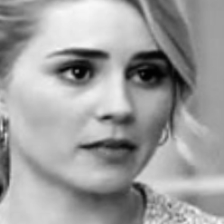

In [10]:
to_pil_transform = torchvision.transforms.ToPILImage()
to_pil_transform(dataset[0][1])

In [11]:
!zip -9 faceid_preprocessed.zip /kaggle/temp/youtube-faces-with-facial-keypoints/*.npz.pkl /kaggle/temp/youtube-faces-with-facial-keypoints/*.csv

  adding: kaggle/temp/youtube-faces-with-facial-keypoints/AJ_Cook_0.npz.pkl (deflated 83%)
  adding: kaggle/temp/youtube-faces-with-facial-keypoints/AJ_Cook_2.npz.pkl (deflated 80%)
  adding: kaggle/temp/youtube-faces-with-facial-keypoints/Aaron_Eckhart_0.npz.pkl (deflated 80%)
  adding: kaggle/temp/youtube-faces-with-facial-keypoints/Aaron_Eckhart_1.npz.pkl (deflated 79%)
  adding: kaggle/temp/youtube-faces-with-facial-keypoints/Abba_Eban_0.npz.pkl (deflated 78%)
  adding: kaggle/temp/youtube-faces-with-facial-keypoints/Abba_Eban_5.npz.pkl (deflated 81%)
  adding: kaggle/temp/youtube-faces-with-facial-keypoints/Abdel_Aziz_Al-Hakim_0.npz.pkl (deflated 75%)
  adding: kaggle/temp/youtube-faces-with-facial-keypoints/Abdel_Aziz_Al-Hakim_1.npz.pkl (deflated 79%)
  adding: kaggle/temp/youtube-faces-with-facial-keypoints/Abdel_Aziz_Al-Hakim_4.npz.pkl (deflated 79%)
  adding: kaggle/temp/youtube-faces-with-facial-keypoints/Abdoulaye_Wade_0.npz.pkl (deflated 79%)
  adding: kaggle/temp/youtube-f

In [12]:
!ls -l

total 10482532
---------- 1 root root      924501 Sep 26 12:10 __notebook__.ipynb
-rw-r--r-- 1 root root 10733182508 Sep 26 12:10 faceid_preprocessed.zip
